# **MNIST-1D**: Benchmarking pooling methods
Sam Greydanus

In this notebook, I will examine the effect of pooling on model generalization and sample efficiency. It looks like pooling is better than striding (or no pooling) on small datasets, but the discrepancy decreases as the number of training examples increase. I'm not yet sure why this is, but my best hypothesis is that pooling is a mediocre architectural prior which is better than nothing in low-data regimes and then ends up restricting model expression in high-data regimes. Let me know if you have a better explanation.

This case study is meant to show the convenience and computational savings of working with the low-dimensional MNIST-1D dataset. You can find details at https://github.com/greydanus/mnist1d.

In [12]:
!python -m pip install git+https://github.com/greydanus/mnist1d.git@master

# Download repo directly (gives access to notebooks/models.py and notebooks/train.py)
!git clone https://github.com/greydanus/mnist1d

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import torch, os
import torch.nn as nn
import torch.nn.functional as F

import mnist1d

# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

plt.style.use('https://github.com/greydanus/mnist1d/raw/master/notebooks/mpl_style.txt')

Using: cuda


In [4]:
# from mnist1d.data import get_dataset, get_dataset_args
# from mnist1d.utils import set_seed, to_pickle

import sys ; sys.path.append('./mnist1d/notebooks')
from train import get_model_args, train_model

## Only run this if you're in Google Colab

In [5]:
if True:
    # Only run this in Colab
    from google.colab import drive
    drive.mount('/content/gdrive')
    project_dir = "/content/gdrive/My Drive/Research/mnist1d/"
else:
    project_dir = './'

Mounted at /content/gdrive


## Systematically generate different pooling settings
We'll need to define a custom model for this. It looks similar to the `ConvBase` model in [mnist1d/models.py](https://github.com/greydanus/mnist1d/blob/master/models.py)

In [6]:

class ConvPooling(nn.Module):
    def __init__(self, output_size, channels=20, stride=1, pool_fun=None, linear_in=200, seed=0):
        super(ConvPooling, self).__init__()
        _ = torch.manual_seed(seed) # use same initialization each time
        self.conv1 = nn.Conv1d(1, channels, 3, stride=stride, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, 3, stride=stride, padding=1)
        self.linear = nn.Linear(linear_in, output_size)
        max_pool = lambda x: F.max_pool1d(x, 2)
        self.pool_fun = max_pool if pool_fun is None else pool_fun

    def forward(self, x): # the print statements are for debugging
        x = x.view(-1,1,x.shape[-1])
        h1 = self.pool_fun(self.conv1(x).relu())
        h2 = self.pool_fun(self.conv2(h1).relu())
        h2_flat = h2.view(h2.shape[0], -1) # flatten the conv features
        # print(h2_flat.shape)
        return self.linear(h2_flat) # a linear classifier goes on top

def get_models(args):
  models = [ConvPooling(args.output_size, stride=1, pool_fun=lambda x: x, linear_in=800),
            ConvPooling(args.output_size, stride=2, pool_fun=lambda x: x),
            ConvPooling(args.output_size, stride=1, pool_fun=lambda x: F.max_pool1d(x, 2)),
            ConvPooling(args.output_size, stride=1, pool_fun=lambda x: F.avg_pool1d(x, 2)),
            ConvPooling(args.output_size, stride=1, pool_fun=lambda x: F.lp_pool1d(x, norm_type=2, kernel_size=2))]

  for m, n in zip(models, ['no_pool','stride_2','max_pool','avg_pool','l2_pool']):
    m.name = n
  return models

## Let's see how pooling affects learning in different data regimes

In [7]:
dataset_sizes = [2000, 3000, 6000, 11000, 21000, 51000]
train_splits = [1-(1000./ds) for ds in dataset_sizes]  # split so that there are always 1000 test examples
regime_results = []
for i, num_samples in enumerate(dataset_sizes):

  # make dataset
  data_args = mnist1d.get_dataset_args()
  data_args.num_samples = num_samples
  data_args.train_split = train_splits[i]
  dataset = mnist1d.get_dataset(args=data_args, download=False, regenerate=True)

  # build the models
  model_args = get_model_args()
  model_args.total_steps = 6000
  model_args.eval_every = 100
  model_args.device = DEVICE
  models = get_models(model_args)

  # train the models, save results
  print('\nNew dataset, train set size={}, test set size={}'\
        .format(dataset['x'].shape[0], dataset['x_test'].shape[0]))
  result = [train_model(dataset, m, model_args) for m in models]
  regime_results.append(result)

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...

New dataset, train set size=1000, test set size=1000
step 1000, dt 3.05s, train_loss 1.452e-03, test_loss 2.785e+00, train_acc 100.0, test_acc 59.9
step 2000, dt 1.60s, train_loss 3.115e-04, test_loss 3.279e+00, train_acc 100.0, test_acc 60.1
step 3000, dt 1.57s, train_loss 1.155e-04, test_loss 3.599e+00, train_acc 100.0, test_acc 59.9
step 4000, dt 1.53s, train_loss 5.209e-05, test_loss 3.858e+00, train_acc 100.0, test_acc 59.6
step 5000, dt 1.56s, train_loss 2.587e-05, test_loss 4.088e+00, train_acc 100.0, test_acc 59.0
step 6000, dt 1.53s, train_loss 1.361e-05, test_loss 4.296e+00, train_acc 100.0, test_acc 59.2
step 1000, dt 1.61s, train_loss 1.222e-02, test_loss 2.728e+00, train_acc 100.0, test_acc 57.4
step 2000, dt 1.49s, train_loss 1.769e-03, test_loss 3.687e+00, train_acc 100.0, test_acc 57.2
step 3000, dt 1.55s, train_loss 5.796e-04, test_loss 4.239e+00, train_acc 100.0, test_acc 57.0
step 4000, dt 1.5

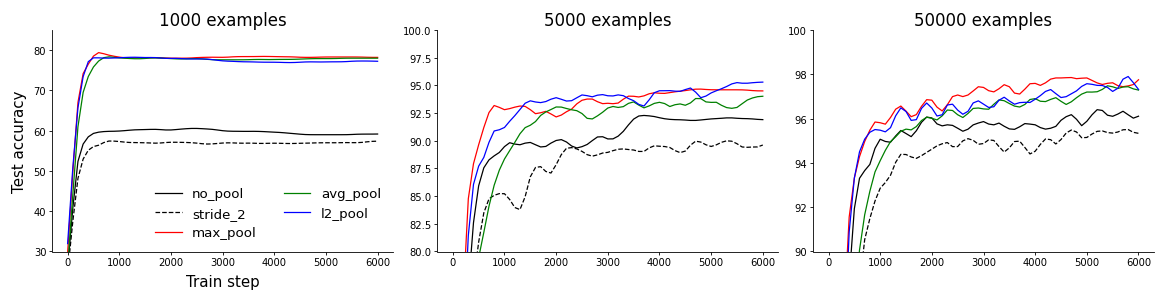

In [11]:
rows, cols = 1, 3
fig = plt.figure(figsize=[cols*3.2,rows*2.4], dpi=120)

t = range(0, model_args.total_steps+1, model_args.eval_every)
styles = ['k-', 'k--', 'r-', 'g-', 'b-']
ylims = [[30,85],[80,100],[90,100]]
runs_to_show = [0, 2, 5]

for r in range(rows):
    for c in range(cols):
        ix = r*cols + c
        ax = plt.subplot(rows,cols,ix+1)

        results = regime_results[runs_to_show[ix]]
        for j, result in enumerate(results):
          model = result['checkpoints'][-1]
          plt.plot(t, gaussian_filter(result['test_acc'], 1), styles[j], label=model.name)

        plt.title('{} examples'.format(dataset_sizes[runs_to_show[ix]]-1000), fontsize=10)
        if ix==0:
          plt.ylabel("Test accuracy", fontsize=9)
          plt.xlabel("Train step", fontsize=9)
        if ix==0:
          plt.legend(fontsize=8, ncol=2)
        plt.ylim(*ylims[ix])

plt.show()
os.makedirs(project_dir + 'figures/', exist_ok=True)
fig.savefig(project_dir + 'figures/pooling.png')
fig.savefig(project_dir + 'figures/pooling.pdf')

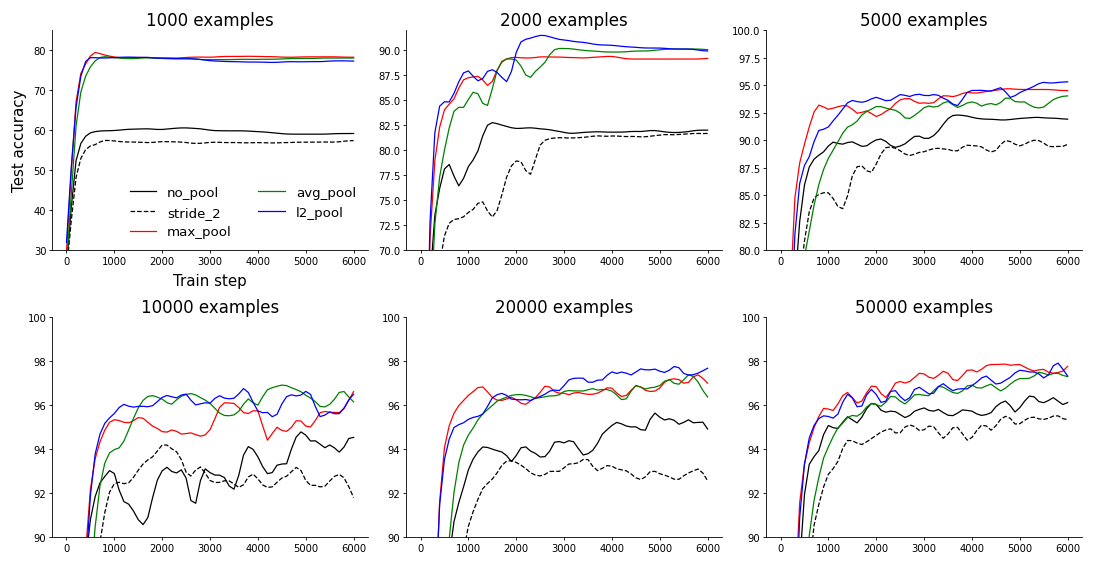

In [10]:
rows, cols = 2, 3
fig = plt.figure(figsize=[cols*3,rows*2.3], dpi=120)

t = range(0, model_args.total_steps+1, model_args.eval_every)
styles = ['k-', 'k--', 'r-', 'g-', 'b-']
ylims = [[30,85],[70,92],[80,100],[90,100],[90,100],[90,100]]

for r in range(rows):
    for c in range(cols):
        ix = r*cols + c
        ax = plt.subplot(rows,cols,ix+1)

        results = regime_results[ix]
        for j, result in enumerate(results):
          model = result['checkpoints'][-1]
          plt.plot(t, gaussian_filter(result['test_acc'], 1), styles[j], label=model.name)

        plt.title('{} examples'.format(dataset_sizes[ix]-1000), fontsize=10)
        if ix==0:
          plt.ylabel("Test accuracy", fontsize=9)
          plt.xlabel("Train step", fontsize=9)
        if ix==0:
          plt.legend(fontsize=8, ncol=2)
        plt.ylim(*ylims[ix])

plt.show()
fig.savefig(project_dir + 'pooling_all.png')
fig.savefig(project_dir + 'pooling_all.pdf')